In [1]:
#Bowerbird null model (all males are guarders)

#Key
#Notes- Paramters contain underscores, while functions don't
#SB: Stay at bower
#FG: Foraging
#a=-1: denotes a staying at bower action on ticket
#a=-2: denotes a foraging action on ticket
#a=-3: denotes a female visiting action on a ticket
#networkwriter: generates network where everybird is connected
#addtotimeline: adds tickets to timeline
#travel_times_linear_p: generates a matrix that contains the probabilities of travelling to a given a bower 
#if the relationship between distance and travel preference is linear
#improb: The probability of traveling improb_distance or less
#improb_distance: The distance at which there is only a (1-improb)% chance of choosing to travel
#lamb: lambda calculated by solving improb=1-np.exp(-lamb*improb_distance)
#bower_states: options are 1(bower intact) and 0 (bower destroyed-will never be the case when all guarders)
#male_states: options are 1 (male present at bower) and 0 (male absent from bower)
#fitness_states: keeps track of number of matings a given male has had
#t: time
#nodes: total number of male bowerbirds in the network




import math
import random
import numpy as np
import matplotlib.pyplot as plt


# makes a ticket
def ticketgenerator(tau,t, o, a):
    ticket={
        'tau': tau,
        'time': t,
        'owner': o,
        'action': a,
    }
    return ticket;

#writes the edges to a network of n birds where everyone is connected to everyone else 
def networkwriter(n):
    connect=[0]*n
    for i in range(0, n): 
        a=list(range(n)) #generating a list that goes from 0 to n-1
        a.remove(i) #individual removes themselves from the network
        connect[i]=a #corresponds to the list of people person i is linked to
    return connect; #returns a list of lists with all the connections in the network


# function for determining the next time based on our rate parameters
def nexttau(action):
    x=-1
    while x<=0:
        switcher = {
            -1: np.random.normal(loc=.1583, scale=.09755, size=1)[0], #choose when to leave bower (generate a tau for bower stay)
            -2: np.random.gamma(shape=1.5, scale=5, size=1)[0]/60, #choose when to stop foraging (generate a tau for foraging)
            -3: random.expovariate(FV_param) #FV_param... totally arbitrary so we should think about it
        }
        x=switcher.get(action, "invalid action")
    return x
    

#adds new tickets to timeline -- Stefano, any more efficient suggestions for keeping timeline in order?
def addtotimeline(tic, timeline):
    if not timeline:
        timeline.append(tic)
    else:
        ind=len(timeline)-1
        end=0
        while (tic['time']<timeline[ind]['time'] and end==0): #moves backwards until it finds where to place the ticket based on the listed times
            ind=ind-1 
            if(ind<0):
                end=1
        ind=ind+1
        timeline.insert(ind, tic)
    

def SBtickethandler (SB_tic, timeline,SB_param, t_max, male_states):
    ow=SB_tic['owner'] 
    male_states[ow]=1
    t=SB_tic['time']
    FG_time=nexttau(-1)+t #We use SB_param because the time represents when the bird leaves the bower
    if FG_time<t_max:
        FG_tic=ticketgenerator(FG_time-t,FG_time,ow,-2) #-2 denotes foraging action
        addtotimeline(FG_tic,timeline)

def FGtickethandler (FG_tic, timeline,FG_param, t_max, male_states):
    ow=FG_tic['owner'] 
    male_states[ow]=0
    t=FG_tic['time']
    SB_time=nexttau(-2)+t #We use FG_param because the time represents when the bird returns to the bower
    if SB_time<t_max:
        SB_tic=ticketgenerator(SB_time-t,SB_time,ow,-1) #-1 denotes staying at bower
        addtotimeline(SB_tic,timeline)
    
def FVtickethandler (FV_tic, timeline, FV_param, t_max, male_states, fitness_states, nodes, female_preferences, travel_times, success_rate, success_times, recents_list):
    ow=FV_tic['owner']
    t=FV_tic['time']
    r=random.random()
    if bower_states[ow]==1 and male_states[ow]==1 and r<success_rate: #if the bower is intact and the male is present
        recents_list=[]
        fitness_states[ow]=fitness_states[ow]+1 #assumption: female always mates if bower is intact and male present
        success_times.append(t)
        new_FV_ow=np.random.choice(list(range(nodes)))
        decider=random.random() #decide whether female will mate for a second time
        new_FV_time=t+nexttau(-3)
        if new_FV_time<t_max:
            new_FV_tic=ticketgenerator(new_FV_time-t,new_FV_time, new_FV_ow, -3)
            addtotimeline(new_FV_tic, timeline)
    else: #if female does not successfully mate
        recents_list.append(ow)
        if len(recents_list)==nodes:
            recents_list=[]
            print(recents_list)
            new_FV_ow=np.random.choice(list(range(nodes)))
            new_FV_time=t+nexttau(-3)
            if new_FV_time<t_max:
                new_FV_tic=ticketgenerator(new_FV_time-t,new_FV_time, new_FV_ow, -3)
                addtotimeline(new_FV_tic, timeline)
        else:
            new_FV_ow=-1 #just so that the code goes into the while loop the first iteration
            while(new_FV_ow in recents_list or new_FV_ow==-1):
                new_FV_ow=np.random.choice(list(range(nodes)), p=female_preferences[ow]) #choose a male based on preference (a function of distance)
            new_FV_time=t+travel_times[ow][new_FV_ow] #she goes directly to this male
            if new_FV_time<t_max:
                new_FV_tic=ticketgenerator(new_FV_time-t,new_FV_time, new_FV_ow, -3)
                addtotimeline(new_FV_tic, timeline)
    return recents_list
    
#FOR FUTURE: Write a function that generates a probability network of n bowerbirds 



In [2]:
#for now, we write a simple example network with 4 bowers forming a square
nodes=4
d=150

def distances(nodes,d):
    distances = np.array([[d]*nodes]*nodes) #(dist in m)initialize a nodes-by-nodes matrix (1st nrows, 2nd ncols)
for i in range(nodes):
    distances[i][i]=9999.0 #or math.inf but that makes the matrix disp ugly
for i in range(2):
    distances[i][i+2]=((2*(d**2)))**(1/2)
    distances[i+2][i]=((2*(d**2)))**(1/2)
print(distances)
    
#HOW TO REPRESENT INDIVIDUAL'S DIST FROM SELF? nan?


bird_speed=12*3600 #m/hr (12m/s)
travel_times=np.array([[0.0]*nodes]*nodes)
for i in range(nodes):
    for j in range(nodes):
        travel_times[i][j]=distances[i][j]/bird_speed
print(travel_times) #right now the numbers on the diagonals aren't accurate, but we can't have the bird choosing to go to it's own node

#solve for lambda 
improb=0.99
improb_distance=800
lamb=-math.log(1-improb)/improb_distance

#will write female preference based on cumulative exponential decay (lambda=.00576)
female_preferences=np.array([[0.]*nodes]*nodes)

for i in range(nodes):
    for j in range(nodes):
        female_preferences[i][j]=math.exp(-lamb*distances[i][j])        
    female_preferences[i]=female_preferences[i]/sum(female_preferences[i])
print(female_preferences)


[[9999.          150.          212.13203436  150.        ]
 [ 150.         9999.          150.          212.13203436]
 [ 212.13203436  150.         9999.          150.        ]
 [ 150.          212.13203436  150.         9999.        ]]
[[0.23145833 0.00347222 0.00491046 0.00347222]
 [0.00347222 0.23145833 0.00347222 0.00491046]
 [0.00491046 0.00347222 0.23145833 0.00347222]
 [0.00347222 0.00491046 0.00347222 0.23145833]]
[[8.83582673e-26 3.70465006e-01 2.59069988e-01 3.70465006e-01]
 [3.70465006e-01 8.83582673e-26 3.70465006e-01 2.59069988e-01]
 [2.59069988e-01 3.70465006e-01 8.83582673e-26 3.70465006e-01]
 [3.70465006e-01 2.59069988e-01 3.70465006e-01 8.83582673e-26]]


In [3]:
#just a test

#Parameters:
t=0 #start at time 0
t_max=12
timeholder=0
timeline=[] #initialize the timeline
#We've moved away from using these params with expovariate (how we handle FV is still TBD)
#So THE BELOW 3 SHOULD BE COMMENTED OUT (but rn we don't want the handler funcs to yell at us)
FV_param=0.2 #nodes/0.19 #totally random
FG_param=3 #larger values lead to foraging ending earlier, because taus are smaller
SB_param=1.5 #larger values lead to bowerstay ending earlier, because taus are smaller
nodes=4
bower_states=[1]*nodes
male_states=[1]*nodes
fitness_states=[0]*nodes
success_rate=1
success_times=[]
recents_list=[]

    
first_male=random.choice(list(range(nodes))) #The lucky bowerbird that is chosen by the female first
first_female_time=t+nexttau(-3) #determine the time when the first female arrives
first_female_tic=ticketgenerator(first_female_time-t,first_female_time, first_male, -3) #first female ticket
addtotimeline(first_female_tic, timeline)

for i in range(nodes):
    init_FG_time=t+nexttau(-1) #Init FG time indicates when SB ends, thus the tau is generated by SB_param
    init_FG_tic=ticketgenerator(init_FG_time-t,init_FG_time, i, -2)
    addtotimeline(init_FG_tic, timeline)
        


In [4]:
#while loop

while t<t_max:
    #print(t)
    if timeholder>(len(timeline)-1): #if timeholder exceeds max timeline index
        #print(sum(ppl_state)/num_ppl)
        print('end')
        break
    next_tic=timeline[timeholder] #look at the ticket corresponding to where we are on the timeline
    if (next_tic['action']==-1): #if it's a stay-at-bower ticket, use the corresponding handler
        SBtickethandler(next_tic,timeline,SB_param,t_max,male_states)
    elif (next_tic['action']==-2): #if it's a forage ticket use the corresponding handler
        FGtickethandler(next_tic,timeline,FG_param,t_max,male_states)
    else: #if it's a female visit ticket, use the corresponding handler
        print("passing to FVtickethandler")
        recents_list=FVtickethandler(next_tic, timeline, FV_param, t_max, male_states, fitness_states, nodes, female_preferences, travel_times, success_rate, success_times, recents_list)
    t=next_tic['time'] #new time based on the ticket we just read
    timeholder=timeholder+1 #increment timeholder

print(timeline)


passing to FVtickethandler
recents list passed in to function
[]
passing to FVtickethandler
recents list passed in to function
[2]
passing to FVtickethandler
recents list passed in to function
[2, 0]
passing to FVtickethandler
recents list passed in to function
[2, 0, 1]
[]
passing to FVtickethandler
recents list passed in to function
[]
passing to FVtickethandler
recents list passed in to function
[0]
passing to FVtickethandler
recents list passed in to function
[0, 1]
passing to FVtickethandler
recents list passed in to function
[0, 1, 2]
[]
passing to FVtickethandler
recents list passed in to function
[]
passing to FVtickethandler
recents list passed in to function
[0]
passing to FVtickethandler
recents list passed in to function
[0, 1]
passing to FVtickethandler
recents list passed in to function
[0, 1, 3]
[]
passing to FVtickethandler
recents list passed in to function
[]
passing to FVtickethandler
recents list passed in to function
[0]
passing to FVtickethandler
recents list pass

In [5]:
d={}


for i in range(nodes):
    d["tl{0}".format(i)]=[]
for j in range(len(timeline)):
    #for i in range(nodes):
     #   if timeline[j]['owner']==i:
    d["tl{0}".format(timeline[j]['owner'])].append(timeline[j])
    

print("tl0----")
print(d["tl0"])
print("tl1----")
print(d["tl1"])
print("tl2----")
print(d["tl2"])
print("tl3----")
print(d["tl3"])  

for i in range(nodes):
    tl=d["tl{0}".format(i)]
    l=len(tl)
    ta=[0]
    fem=[]
    for j in range(l):
        if tl[j]['action']!=-3: #female visit taus don't mean anything for the male bc she isn't necessarily coming back to the same male
            ta.append(tl[j]['time'])
        else:
            fem.append(tl[j]['time'])
    d["times{0}".format(i)]=ta
    d["fvtimes{0}".format(i)]=fem

print("times0----")
print(d["times0"])
print("times1----")
print(d["times1"])
print("times2----")
print(d["times2"])
print("times3----")
print(d["times3"]) 

#append tmax - sumoftaus to each list (so it reaches tmax exactly)
for i in range(nodes):
    d["times{0}".format(i)].append(t_max)


import csv
timess=[d["times0"],d["times1"],d["times2"],d["times3"]]
csvfile = "example_times2"
with open(csvfile, "w") as output:
    writer = csv.writer(output, lineterminator='\n')
    writer.writerows(timess)
femtimess=[d["fvtimes0"],d["fvtimes1"],d["fvtimes2"],d["fvtimes3"]]
csvfile = "example_fvtimes"
with open(csvfile, "w") as output:
    writer = csv.writer(output, lineterminator='\n')
    writer.writerows(femtimess)

           
    

tl0----
[{'tau': 0.2903921721854351, 'time': 0.2903921721854351, 'owner': 0, 'action': -2}, {'tau': 0.06068981706481247, 'time': 0.3510819892502476, 'owner': 0, 'action': -1}, {'tau': 0.2436634250446743, 'time': 0.5947454142949219, 'owner': 0, 'action': -2}, {'tau': 0.10323015568332972, 'time': 0.6979755699782516, 'owner': 0, 'action': -1}, {'tau': 0.2536596683615865, 'time': 0.9516352383398381, 'owner': 0, 'action': -2}, {'tau': 0.011802448659481435, 'time': 0.9634376869993195, 'owner': 0, 'action': -1}, {'tau': 0.03878466572147454, 'time': 1.002222352720794, 'owner': 0, 'action': -2}, {'tau': 0.08581478381004981, 'time': 1.0880371365308439, 'owner': 0, 'action': -1}, {'tau': 0.2703843808055466, 'time': 1.3584215173363905, 'owner': 0, 'action': -2}, {'tau': 0.18412175943186426, 'time': 1.5425432767682548, 'owner': 0, 'action': -1}, {'tau': 0.004910463758240002, 'time': 1.7154599316433226, 'owner': 0, 'action': -3}, {'tau': 0.21839695309825813, 'time': 1.7609402298665129, 'owner': 0, '

In [6]:
for i in range(nodes):
    tl=d["tl{0}".format(i)]
    l=len(tl)
    ta=[]
    accSB=0
    accFG=0
    for j in range(l):
        if tl[j]['action']!=-3: #female visit taus don't mean anything for the male bc she isn't necessarily coming back to the same male
            ta.append(tl[j]['tau'])
            if tl[j]['action']==-1:
                accSB=accSB+tl[j]['tau']
            else:
                accFG=accFG+tl[j]['tau']
    
    d["taus{0}".format(i)]=ta
    print("Bird {:d}'s % time at bower is {:f}".format(i, accFG/12)) ##VERY ODD -- could it be that FG/SB are switched

#print("taus0----")
#print(d["taus0"])
#print(sum(d["taus0"]))
#print("taus1----")
#print(d["taus1"])
#print(sum(d["taus1"]))
#print("taus2----")
#print(d["taus2"])
#print(sum(d["taus2"]))
#print("taus3----")
#print(d["taus3"]) 
#print(sum(d["taus3"]))


#append tmax - sumoftaus to each list (so it reaches tmax exactly)
#for i in range(nodes):
#    d["taus{0}".format(i)].append(t_max-sum(d["taus{0}".format(i)]))

    
#print(sum(d["taus0"]))
#print(sum(d["taus1"]))
#print(sum(d["taus2"]))
#print(sum(d["taus3"]))  

Bird 0's % time at bower is 0.615647
Bird 1's % time at bower is 0.591601
Bird 2's % time at bower is 0.581329
Bird 3's % time at bower is 0.568585


In [7]:
#Create travel_time__linear_p (might use later)
travel_times_linear_p=np.array([[0.0]*nodes]*nodes)
for i in range(nodes):
    for j in range(nodes):
        if i==j: #if the row and the column index are the equal
            travel_times[i][j]=0 #There is 0 probability they will travel to their own bower when choosing to fly to another bower
        else: 
            if i==0: #if on the first row of the probability matrix
                travel_times_linear_p[i][j]=travel_times[i][1]/travel_times[i][j] #skip the first element in the row (because it equals 0) and compare probabilities of other elements in the row based on travel distance (negative linear relationship btwn distance and prob)
            else:
                travel_times_linear_p[i][j]=travel_times[i][0]/travel_times[i][j] #use the first element in a row and compare probabilities of other elements in the row based on distance (negative linear relationship btwn distance and prob)
    travel_times_linear_p[i]=travel_times_linear_p[i]/sum(travel_times_linear_p[i]) #normalize the probabilities so they add up to 1
print(travel_times_linear_p)



[[0.         0.36939806 0.26120387 0.36939806]
 [0.36939806 0.         0.36939806 0.26120387]
 [0.26120387 0.36939806 0.         0.36939806]
 [0.36939806 0.26120387 0.36939806 0.        ]]


In [8]:
print(fitness_states)

[0, 0, 1, 0]


In [9]:
ts=[0]*100
for i in range(100):
    ts[i]=np.random.gamma(shape=1.5, scale=5, size=1)[0]/60 #FG
np.mean(ts)

0.11030911157316828

In [10]:
np.mean(np.random.normal(loc=.1583, scale=.09755, size=100)) #SB

0.17049312563556562

In [11]:
ts=[0]*100
for i in range(100):
    ts[i]=nexttau(-2)
np.mean(ts)

0.12510826020882945

In [12]:
print(success_times)

[5.458570130548807]


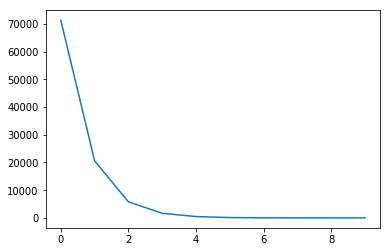

In [13]:
x= [random.expovariate(FV_param) for a in range (0,100000)]
histo, j= np.histogram(x)
plt.plot(histo)
